In [42]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import find_peaks


data=pd.read_csv("AAPL data.csv")
data.head()

CUSIP          ISIN TICKER     SECURITY_TYPE TRADE_DATETIME   PRICE  \
0  037833EB2  US037833EB24   AAPL    AAPL 0.7 02/26  1/2/2023 5:31  89.150   
1  037833AK6  US037833AK68   AAPL    AAPL 2.4 05/23  1/2/2023 6:00  99.389   
2  037833DT4  US037833DT41   AAPL  AAPL 1.125 05/25  1/3/2023 2:00  92.463   
3  037833DF4  US037833DF47   AAPL   AAPL 2.75 01/25  1/3/2023 2:00  96.764   
4  037833AT7  US037833AT77   AAPL   AAPL 4.45 05/44  1/3/2023 2:10  95.390   

     SPREAD QUANTITY  ASSUMED_QUANTITY REPORTING_PARTY_SIDE  \
0  0.267757    50000             50000                    S   
1       NaN    20000             20000                    S   
2  0.110095   340000            340000                    S   
3  0.008494     4000              4000                    S   
4  0.668112    20000             20000                    S   

  REPORTING_PARTY_TYPE CONTRA_PARTY_TYPE MARKET_SEGMENT ANNOUNCEMENT_DATE  \
0                    D                 C     IG                  2/1/2021   
1                    D                 C     IG                 4/30/2013   
2                    D                 A     IG                  5/4/2020   
3                    D                 A     IG                 11/6/2017   
4                    D                 A     IG                 4/29/2014   

   ISSUE_DATE MATURITY_DATE SECTOR  
0    2/8/2021      2/8/2026    TMT  
1    5/3/2013      5/3/2023    TMT  
2   5/11/2020     5/11/2025    TMT  
3  11/13/2017     1/13/2025    TMT  
4    5/6/2014      5/6/2044    TMT

In [43]:
# Data preparation and conversion
data['TRADE_DATETIME'] = pd.to_datetime(data['TRADE_DATETIME'], utc=True)
data['MATURITY_DATE'] = pd.to_datetime(data['MATURITY_DATE'], utc=True, errors='coerce')
data['ANNOUNCEMENT_DATE'] = pd.to_datetime(data['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data['MATURITY_DATE'] = data['MATURITY_DATE'].fillna(perpetuity_date)
data['TRADE_DATETIME'] = data['TRADE_DATETIME'].dt.tz_convert(None)
data['MATURITY_DATE'] = data['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data['PRICE'] = pd.to_numeric(data['PRICE'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')
data['TRADE_VOLUME'] = data['PRICE'] * data['QUANTITY']

In [44]:
# Combine the two columns to create a unique identifier for trade types
data['CombinedTradeType'] = data['REPORTING_PARTY_TYPE'] + '-' + data['CONTRA_PARTY_TYPE']
data['TradeType'] = data['CombinedTradeType'] + '-' + data['REPORTING_PARTY_SIDE']
filtered_data = data[(data['CombinedTradeType'] == 'D-C') | (data['CombinedTradeType'] == 'D-D')]


# Identifying duplicates
duplicates = filtered_data[filtered_data.duplicated(subset=['PRICE', 'QUANTITY', 'TRADE_DATETIME'], keep=False)]

# Handle missing values if any
#filtered_data = filtered_data.dropna()


# Handle duplicates
filtered_data = filtered_data.drop_duplicates()

filtered_data.head()

# Visualization
# Plot the time series of prices
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['TRADE_DATETIME'], filtered_data['PRICE'])  
plt.title('Time Series of Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Top 10 CUSIPs by Count:
037833BY5    13415
037833DK3    11347
037833CG3     9718
037833AS9     8975
037833BX7     6712
037833EP1     6409
037833CJ7     6216
037833CU2     5985
037833BG4     5970
037833ED8     5947
Name: CUSIP, dtype: int64


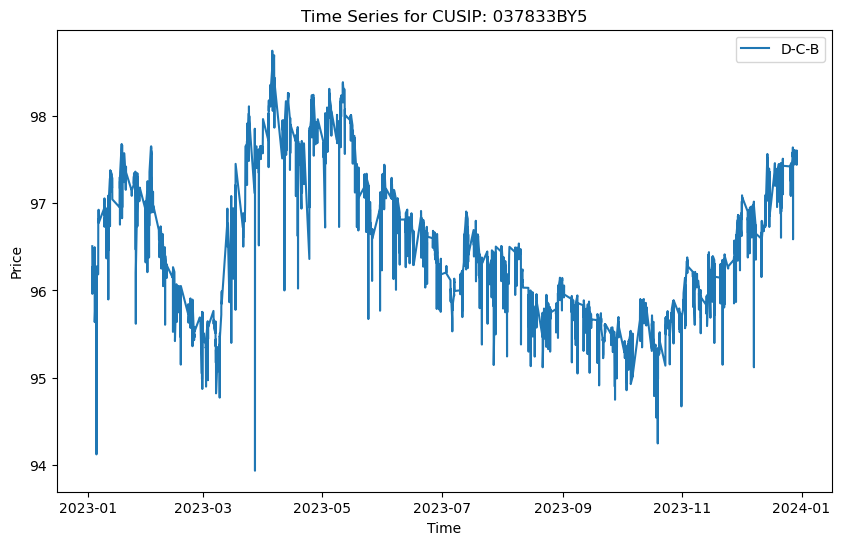

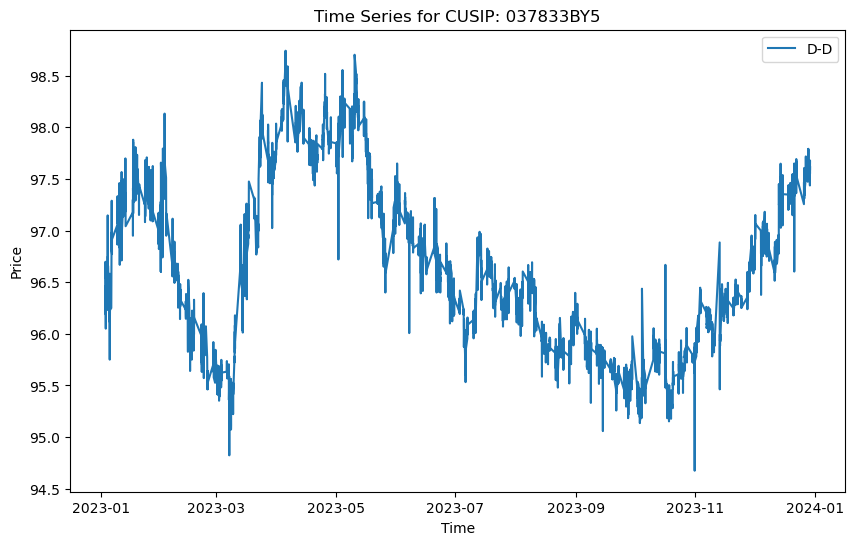

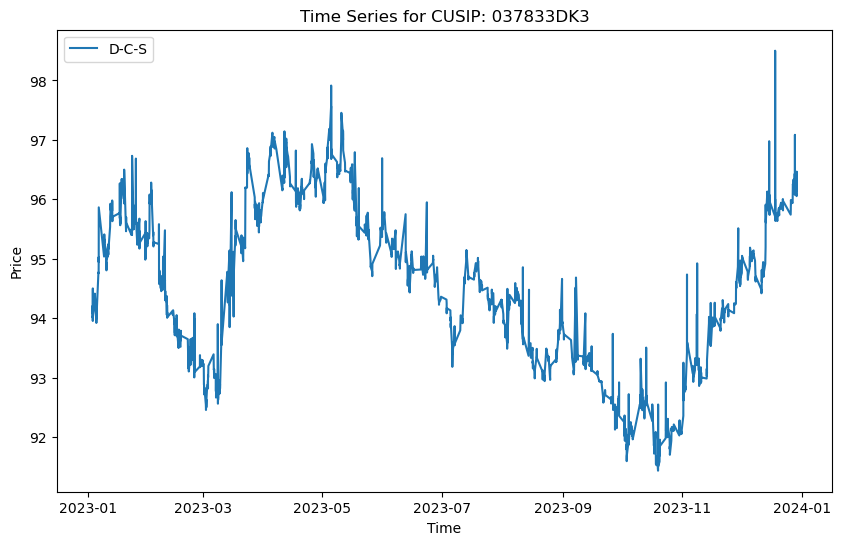

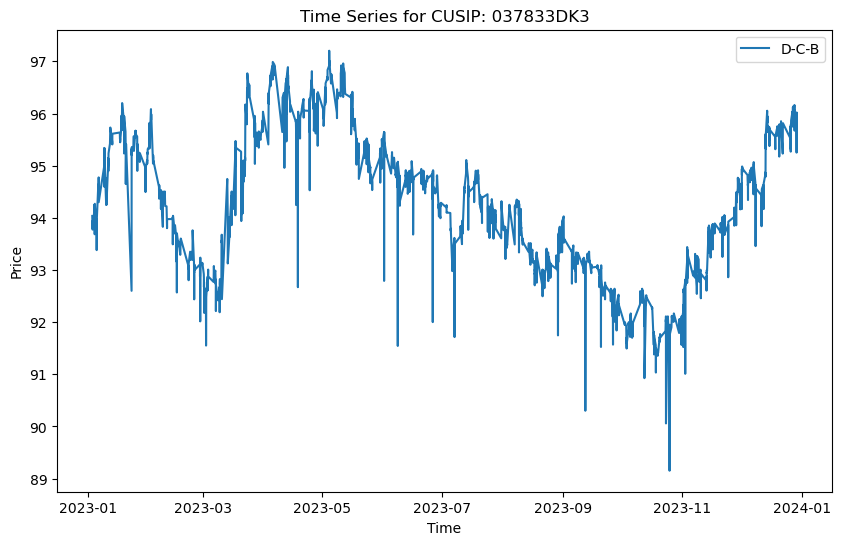

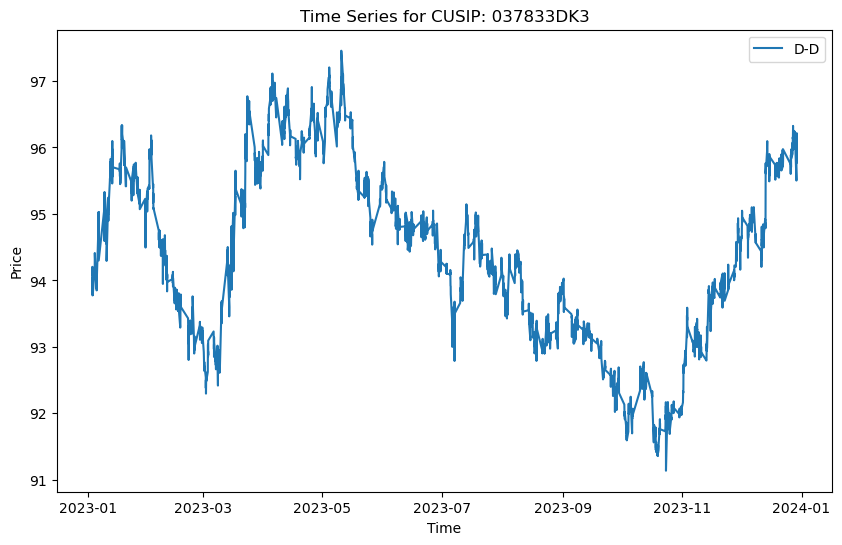

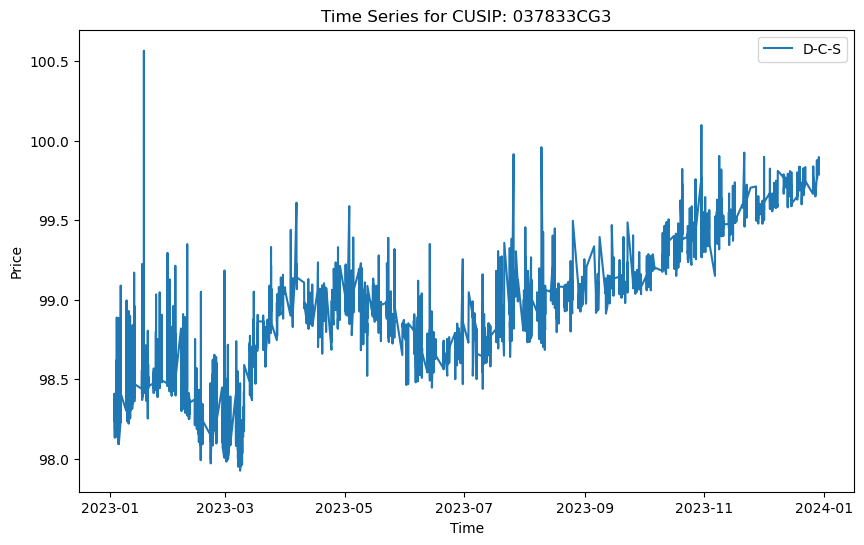

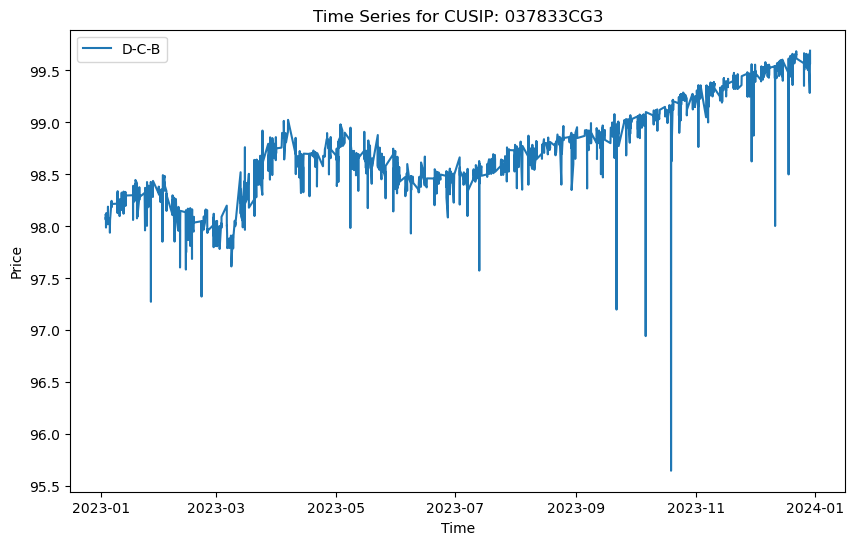

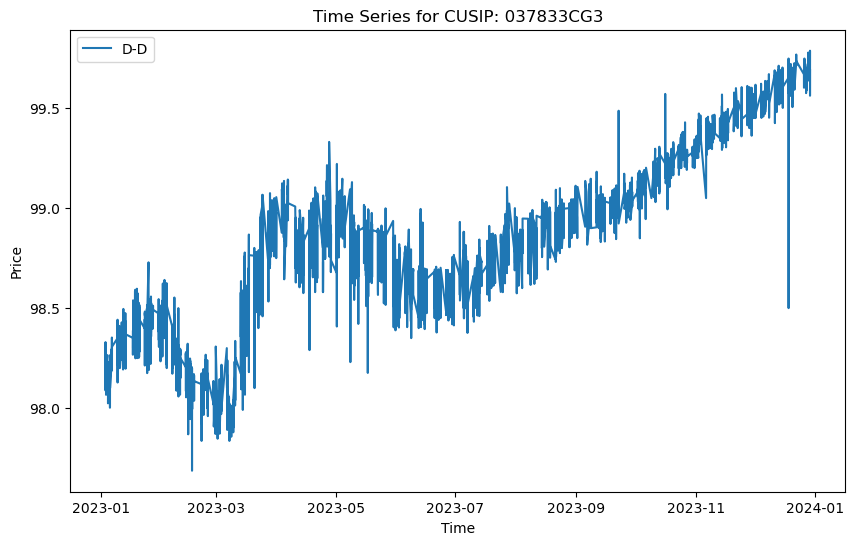

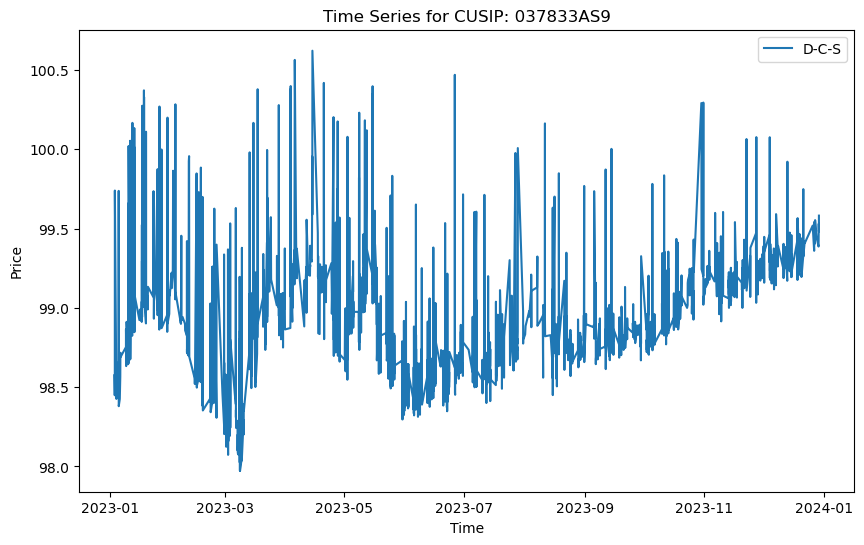

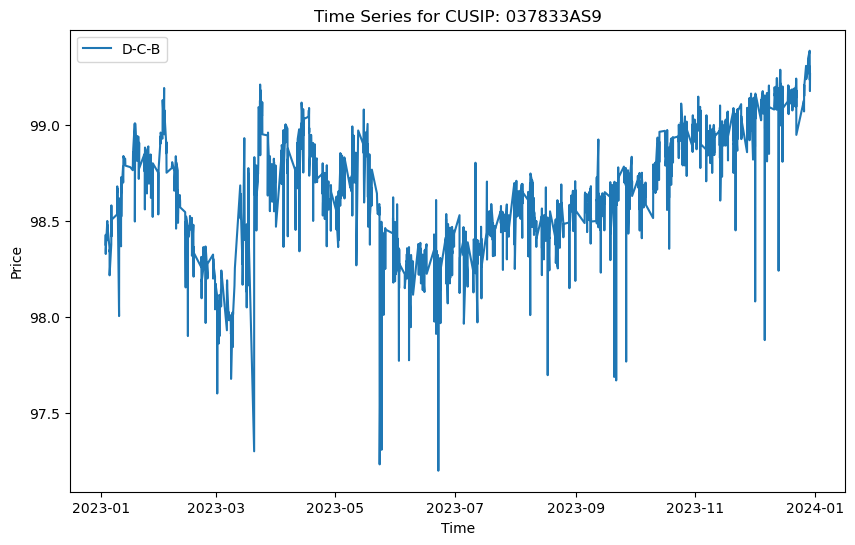

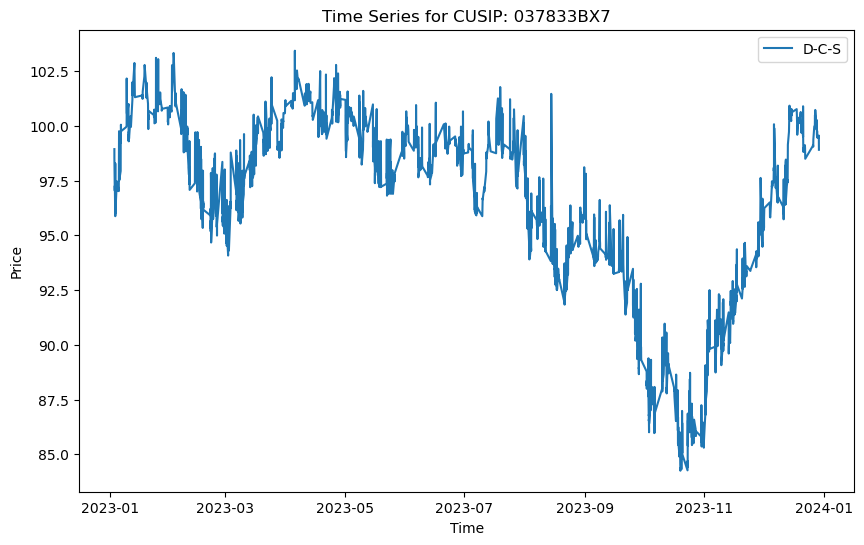

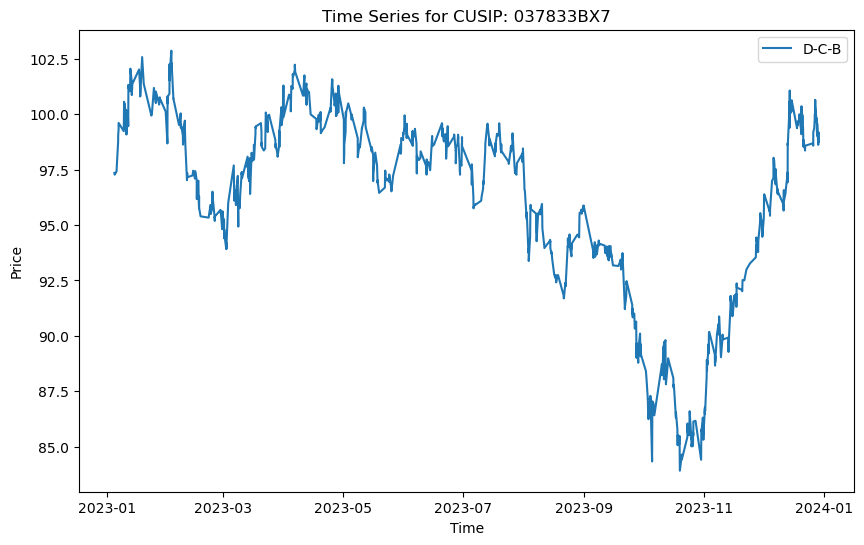

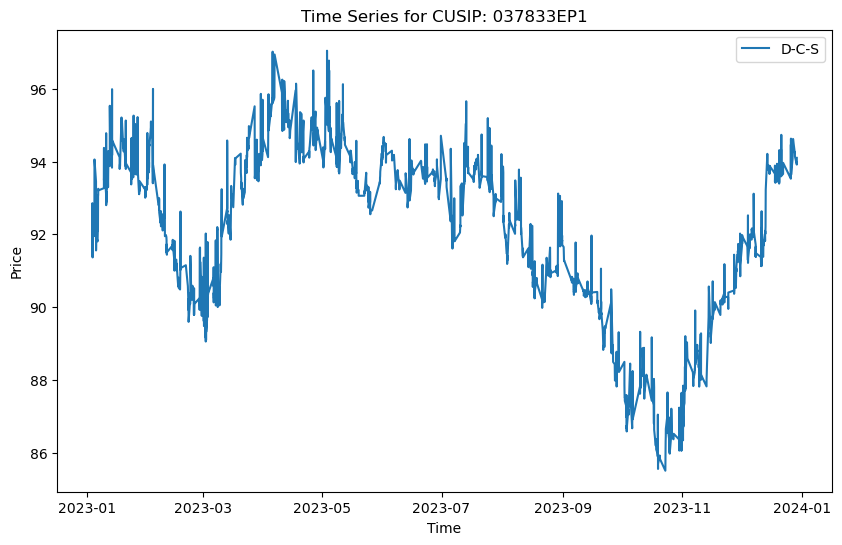

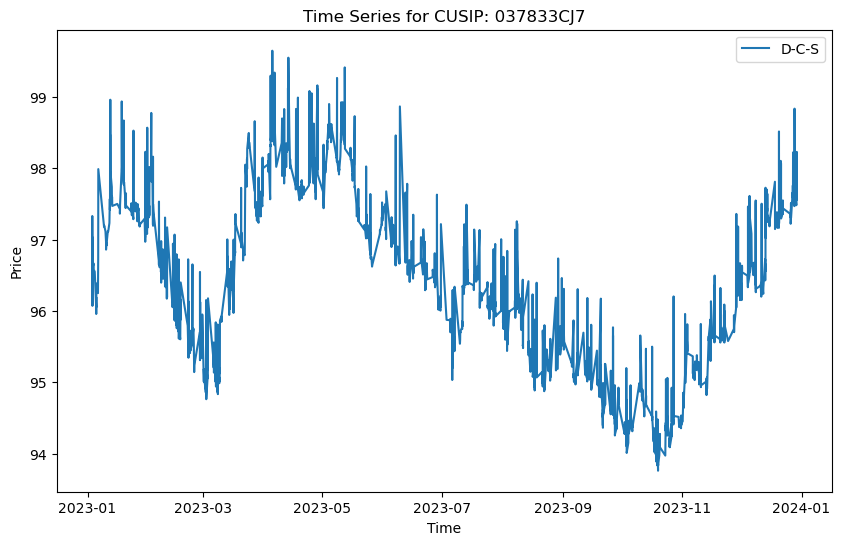

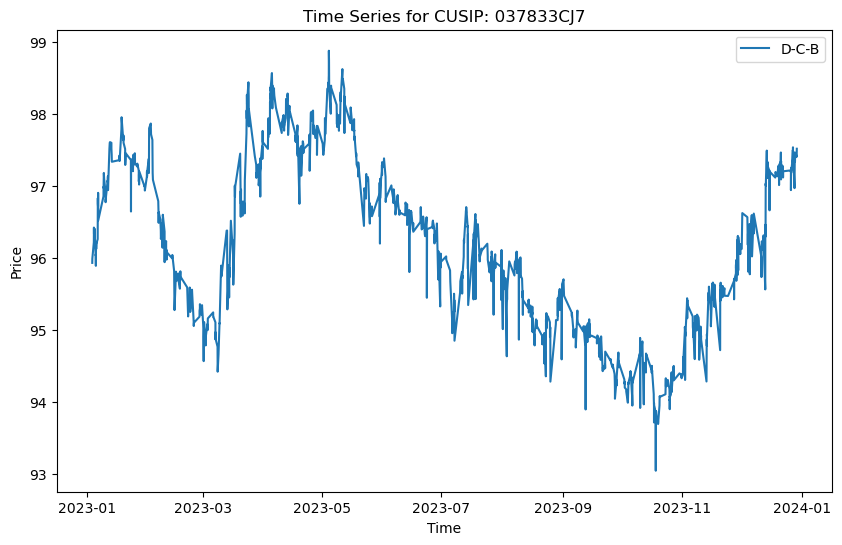

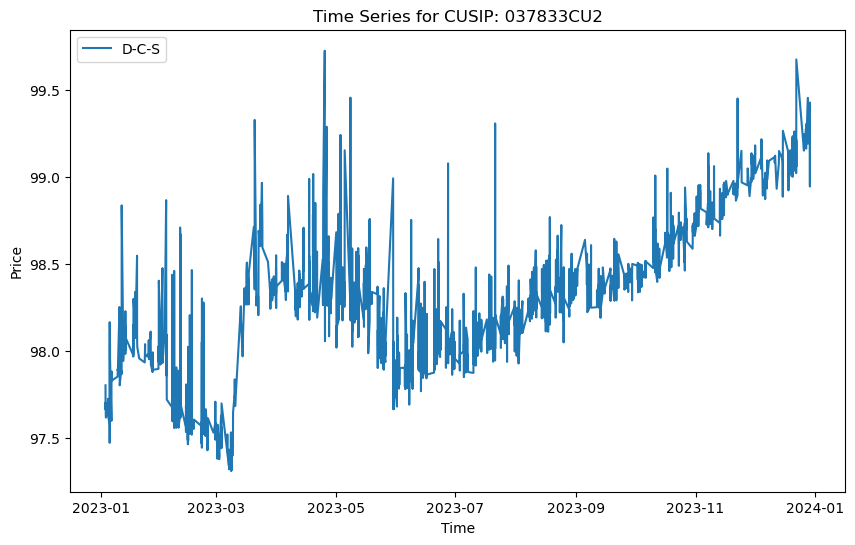

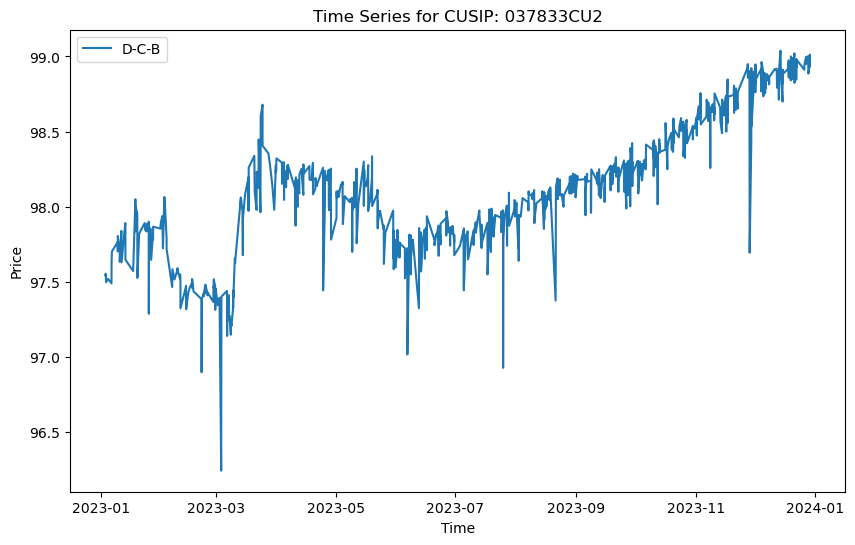

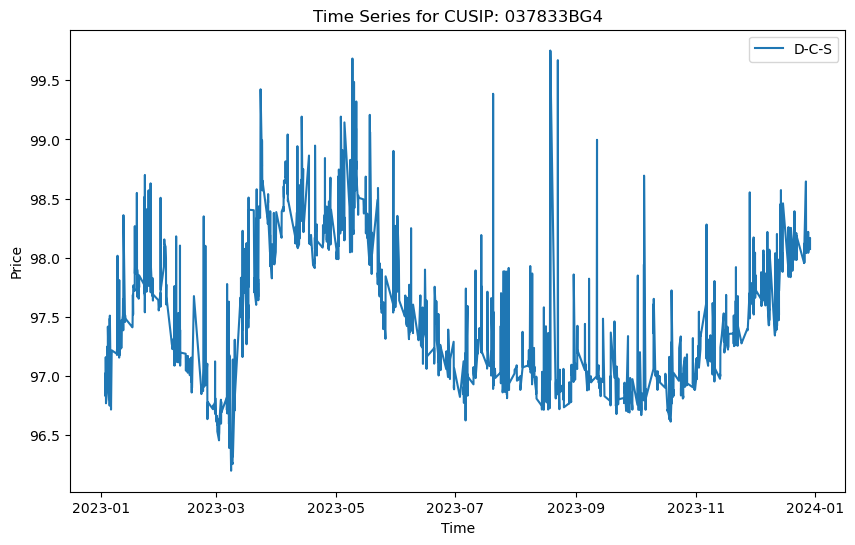

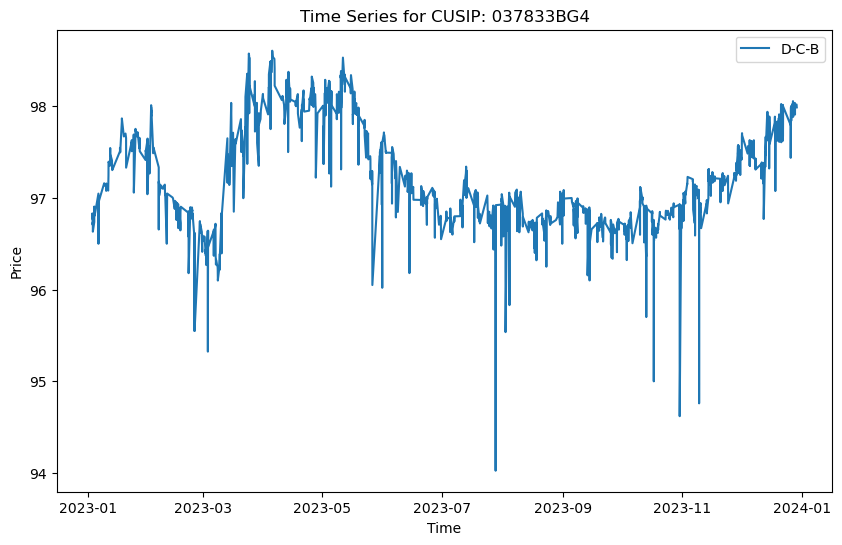

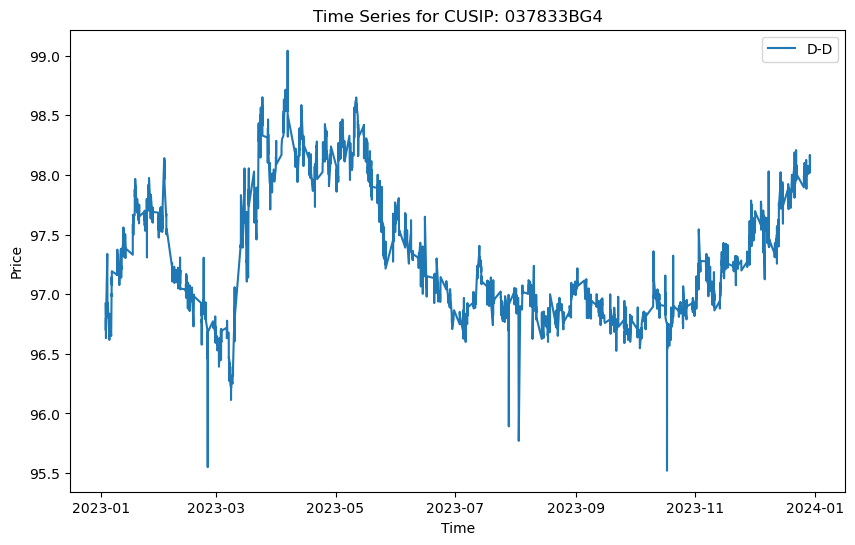

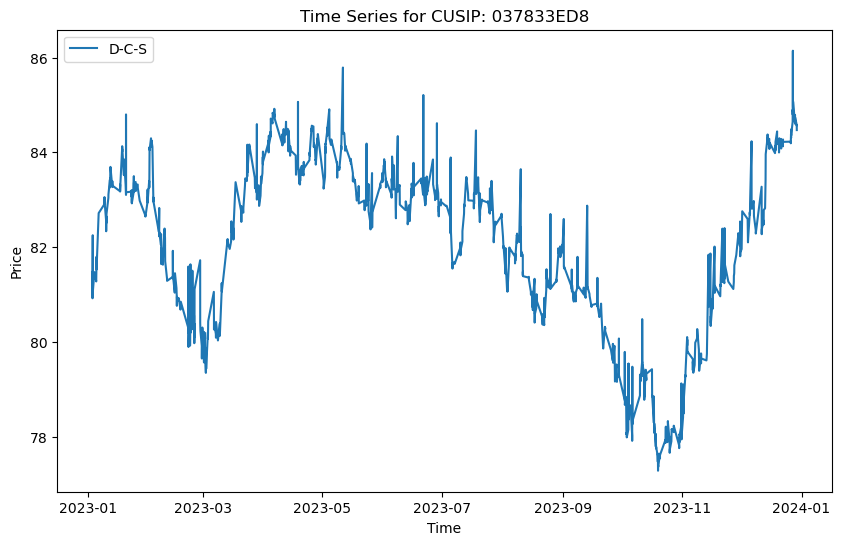

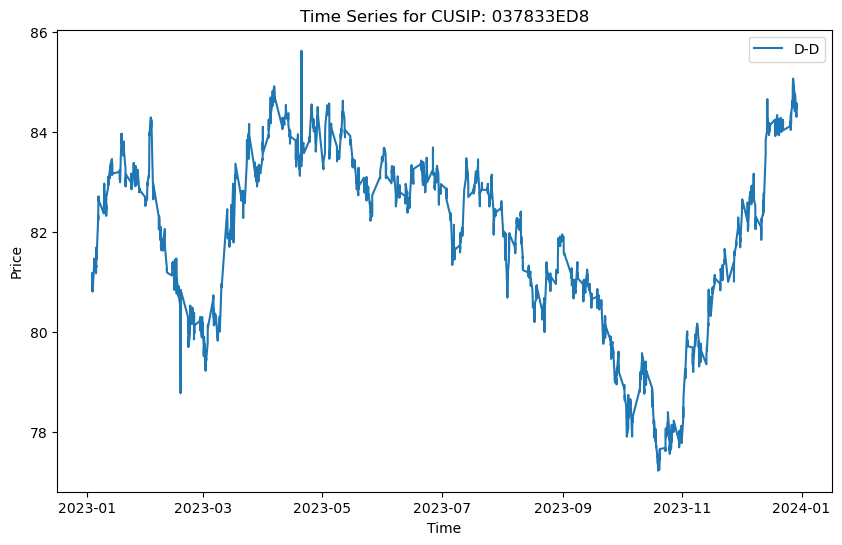

In [45]:
# Count the frequency of TRACE prints for each CUSIP
cusip_counts = filtered_data ['CUSIP'].value_counts()
top_cusips_by_count = cusip_counts.head(10)
print("Top 10 CUSIPs by Count:")
print(top_cusips_by_count)

top_cusips = cusip_counts.head(10).index  # Choose top 10 CUSIPs

# Analyze and plot data for each top CUSIP
for cusip in top_cusips:
    data_cusip = filtered_data [filtered_data ['CUSIP'] == cusip]
    
    # Filter by trade type and plot
    for trade_type in ['D-C-S', 'D-C-B', 'D-D']:
        data_trade = data_cusip[(data_cusip['TradeType'] == trade_type) | 
                                (data_cusip['CombinedTradeType'] == trade_type)]
        
        plt.figure(figsize=(10, 6))
        plt.plot(data_trade['TRADE_DATETIME'], data_trade['PRICE'], label=trade_type)
        plt.title(f'Time Series for CUSIP: {cusip}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

Top 10 CUSIPs by Volume:
CUSIP
037833BX7    1.350957e+11
037833EW6    1.311873e+11
037833EP1    1.255444e+11
037833EQ9    1.222533e+11
037833EV8    1.151455e+11
037833ER7    1.079306e+11
037833BY5    1.002093e+11
037833ET3    9.905213e+10
037833EB2    9.232959e+10
037833DT4    8.531823e+10
Name: TRADE_VOLUME, dtype: float64


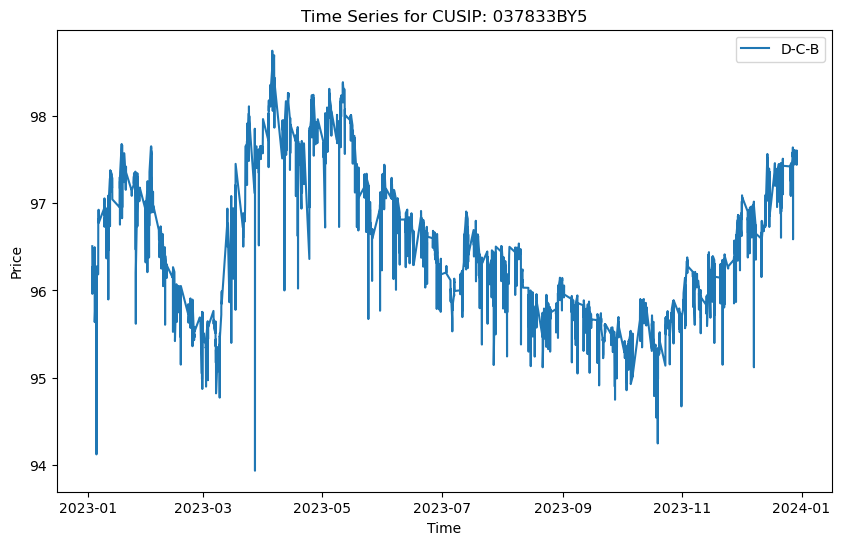

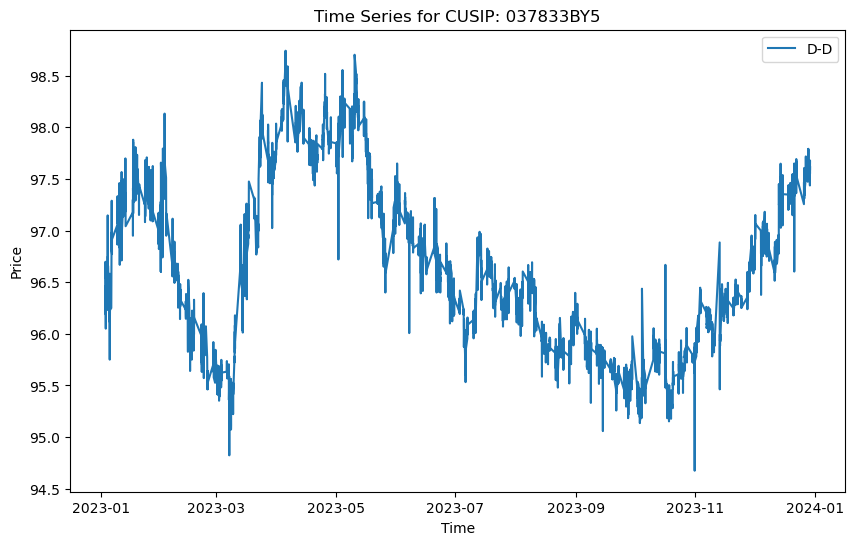

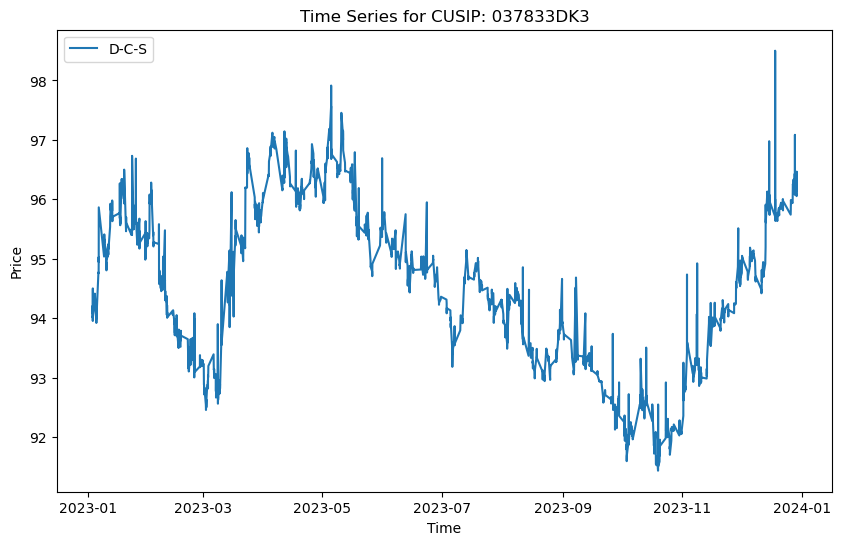

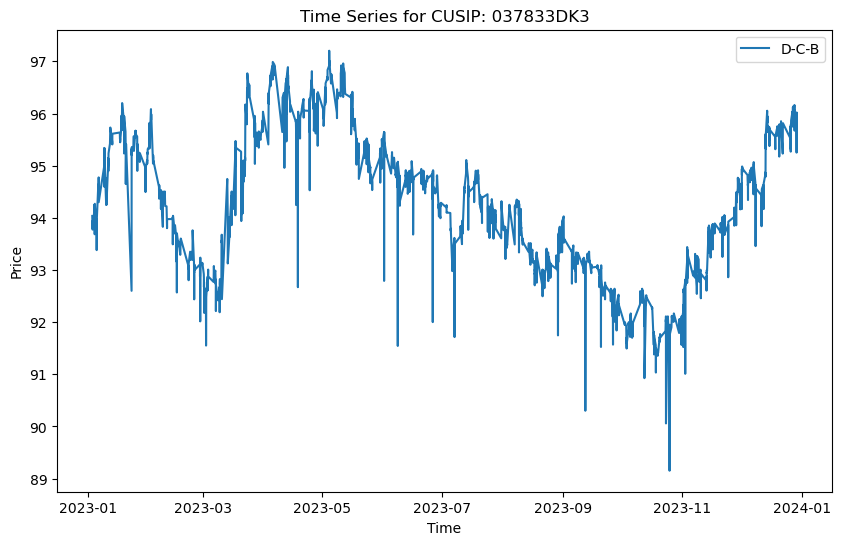

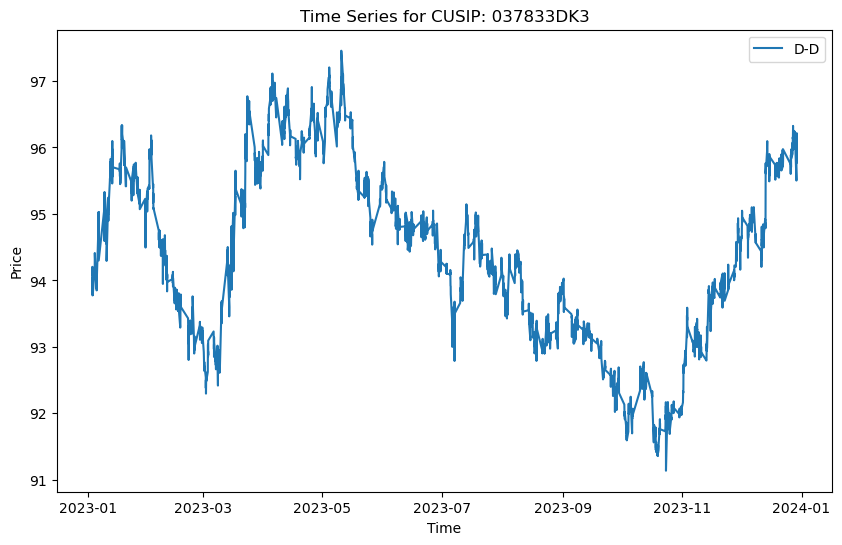

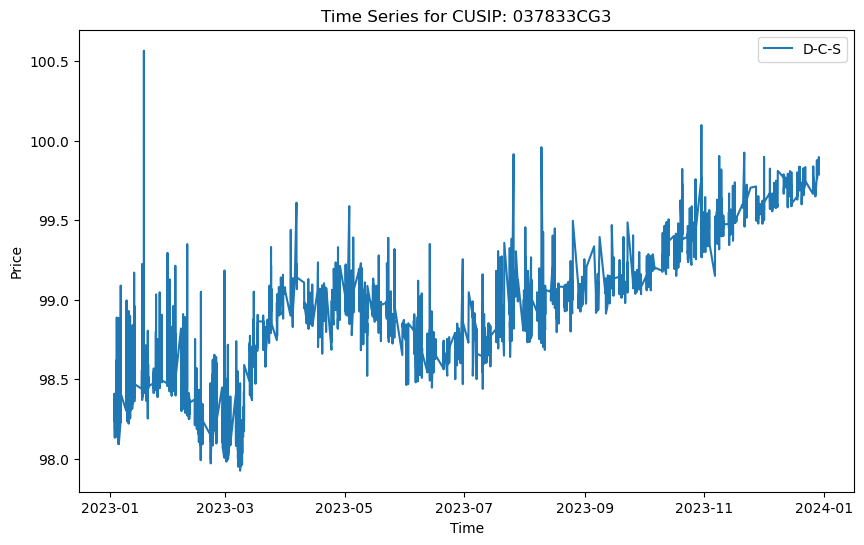

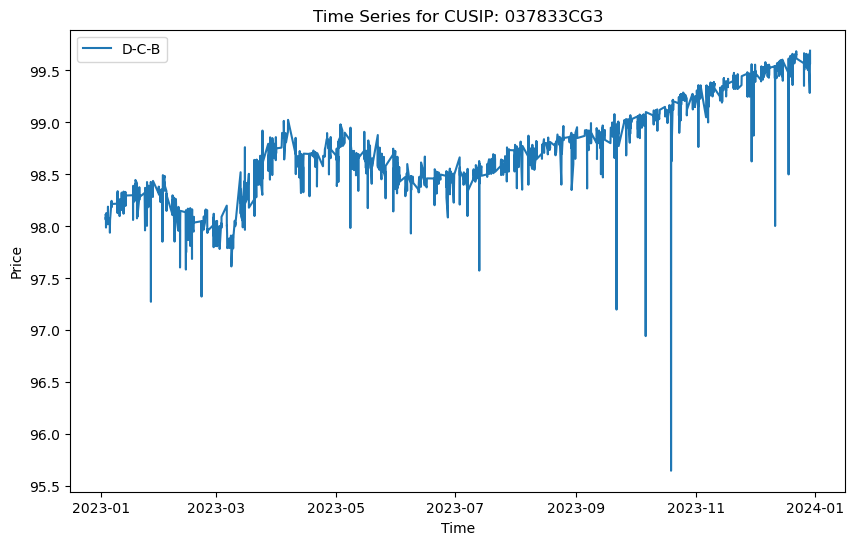

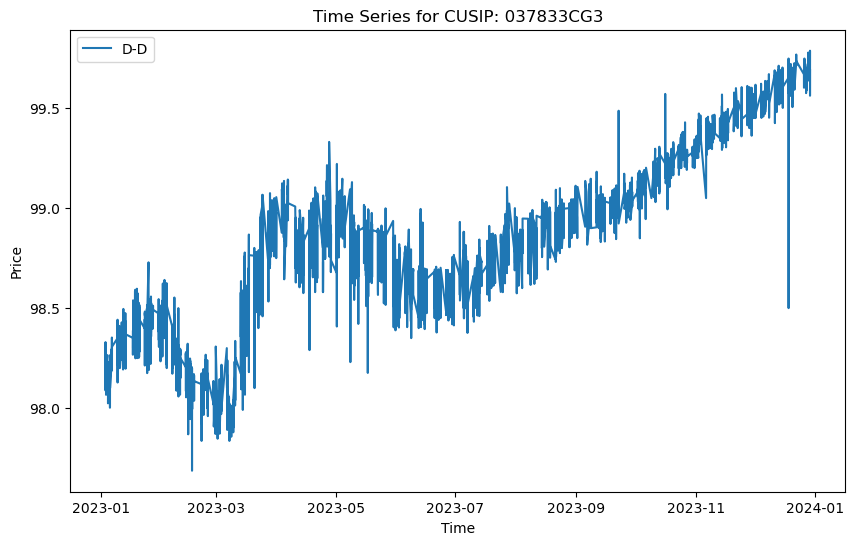

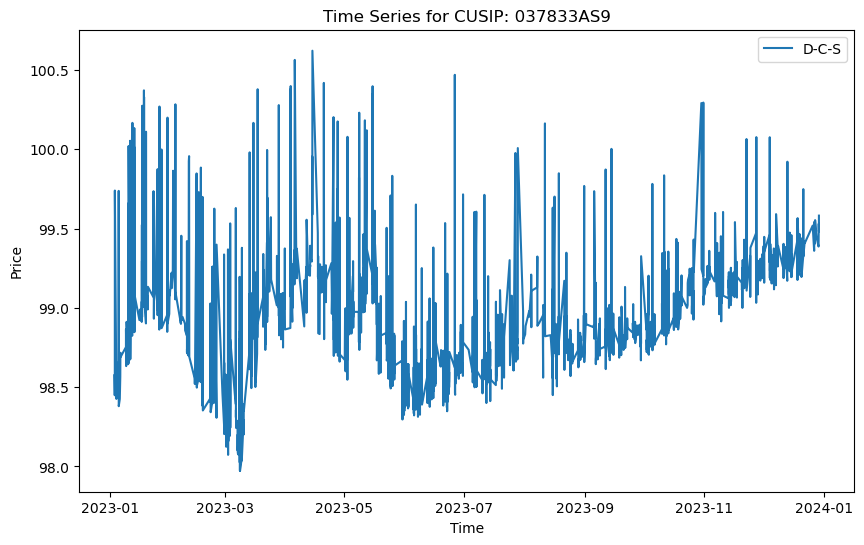

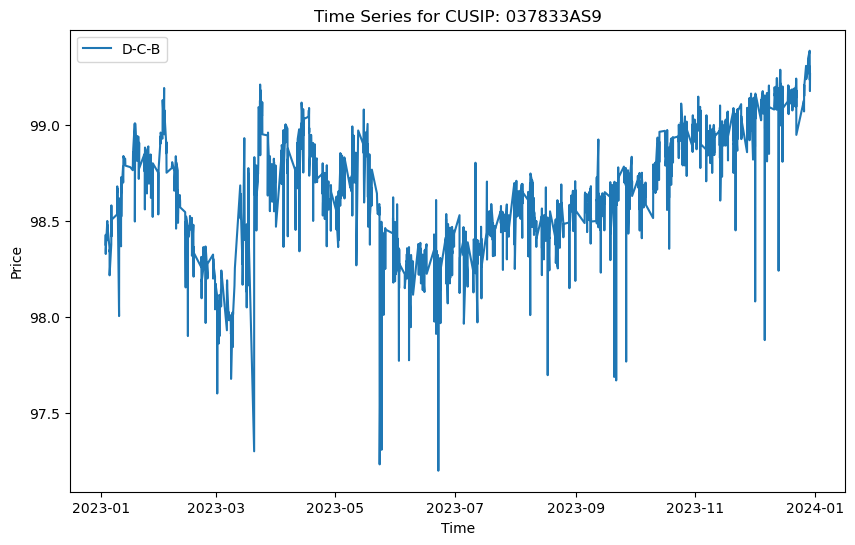

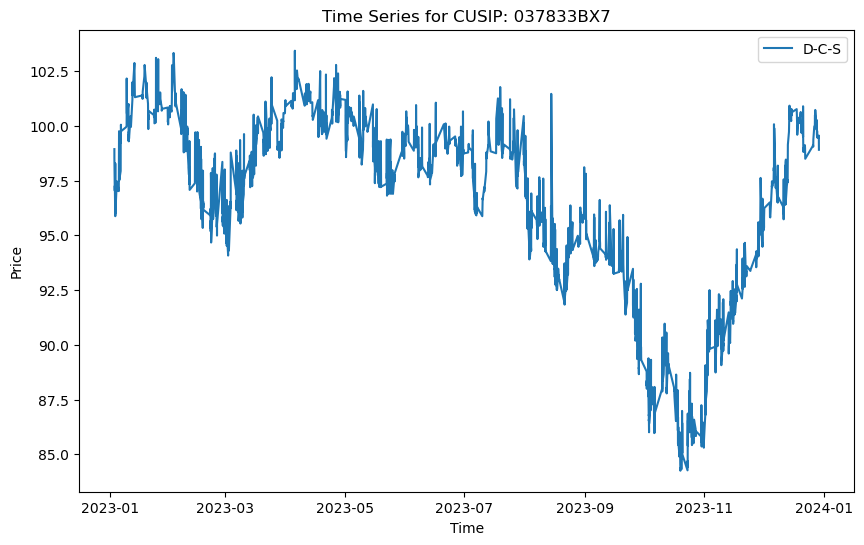

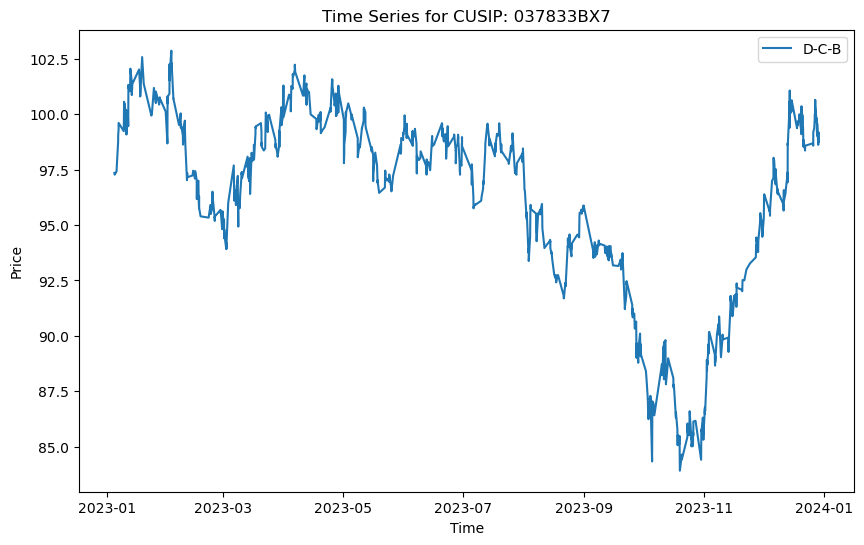

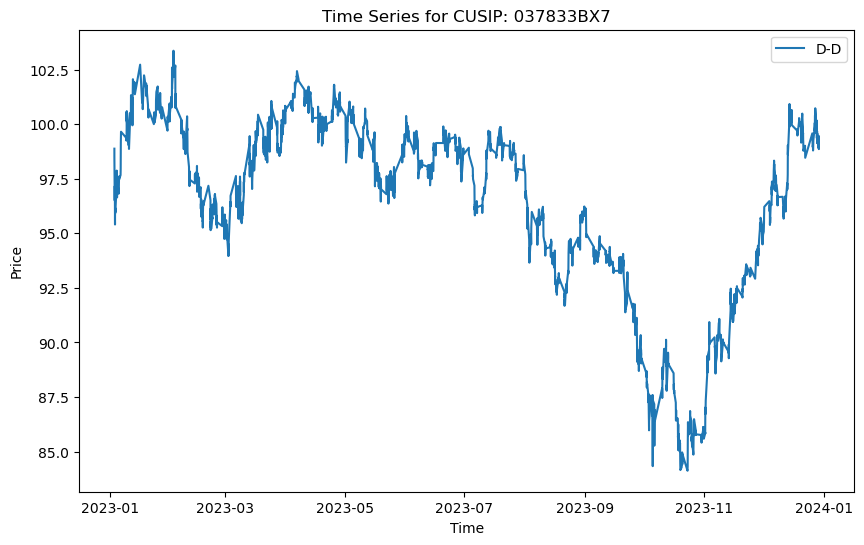

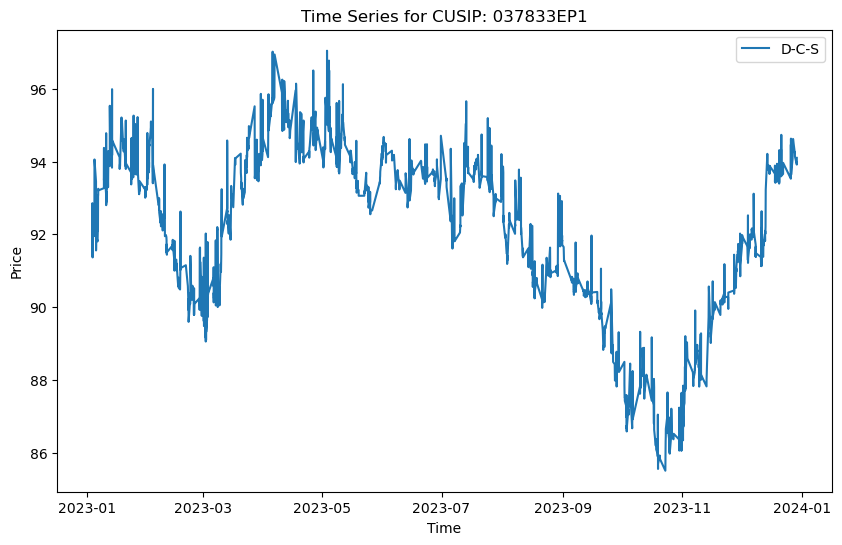

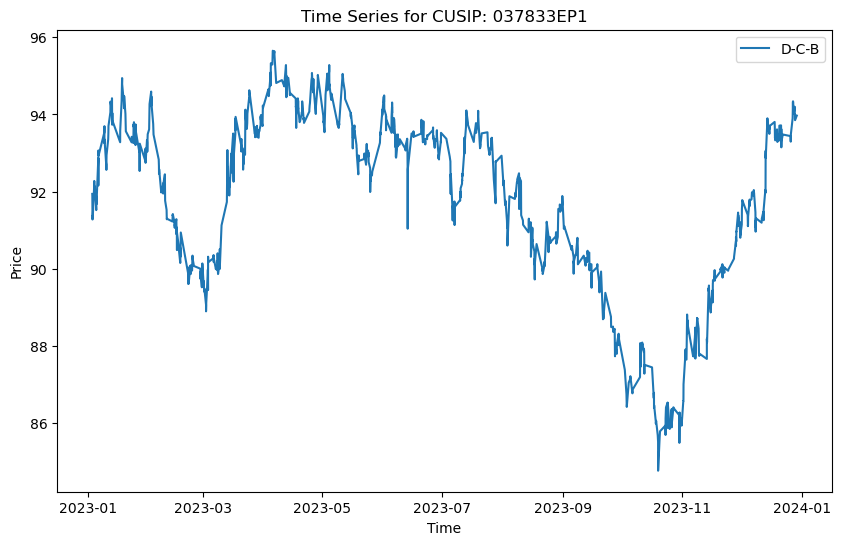

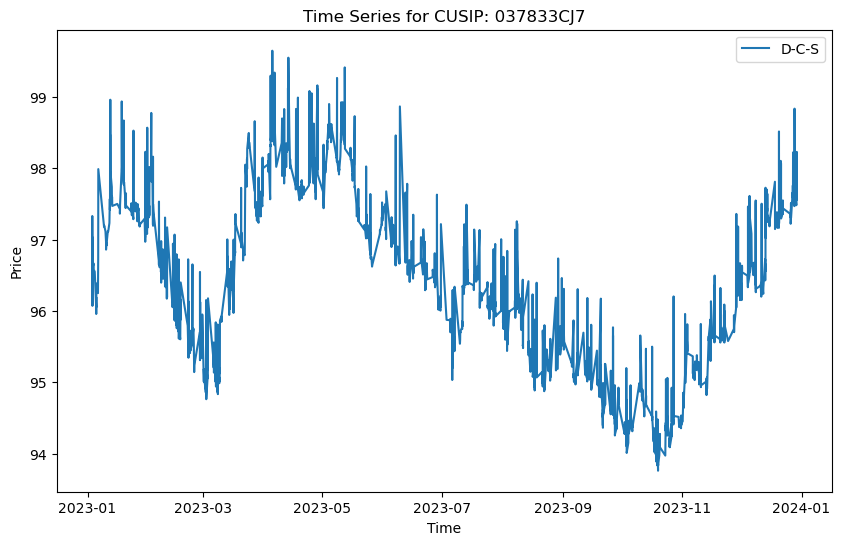

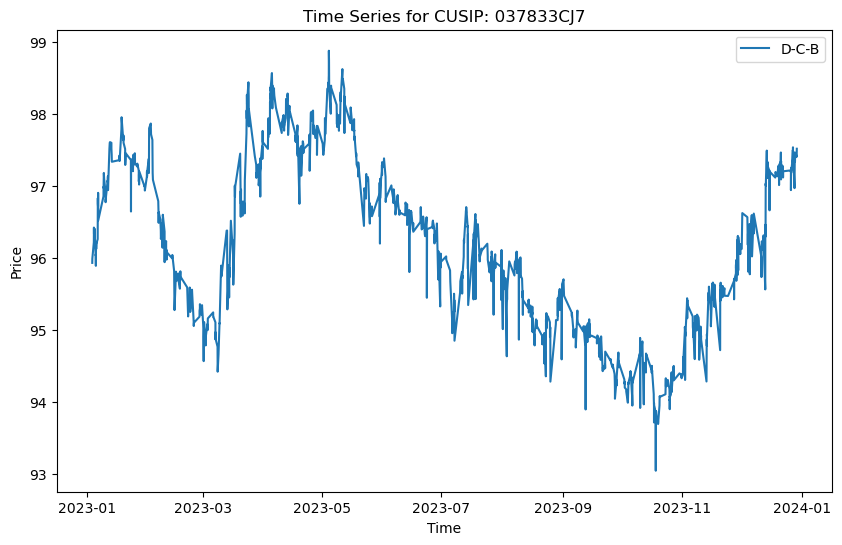

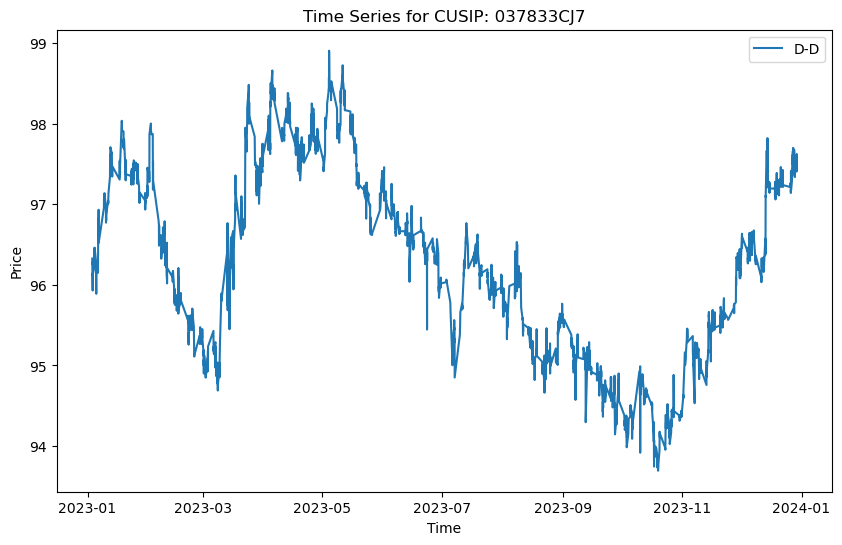

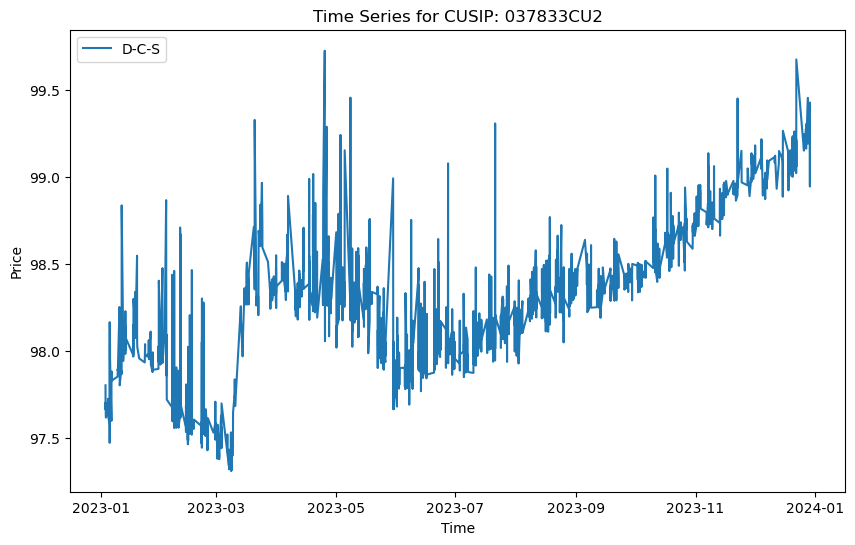

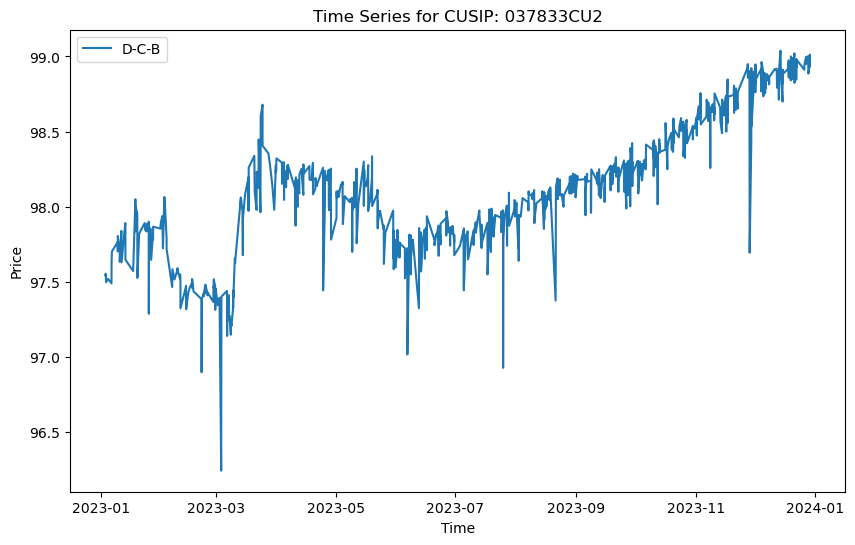

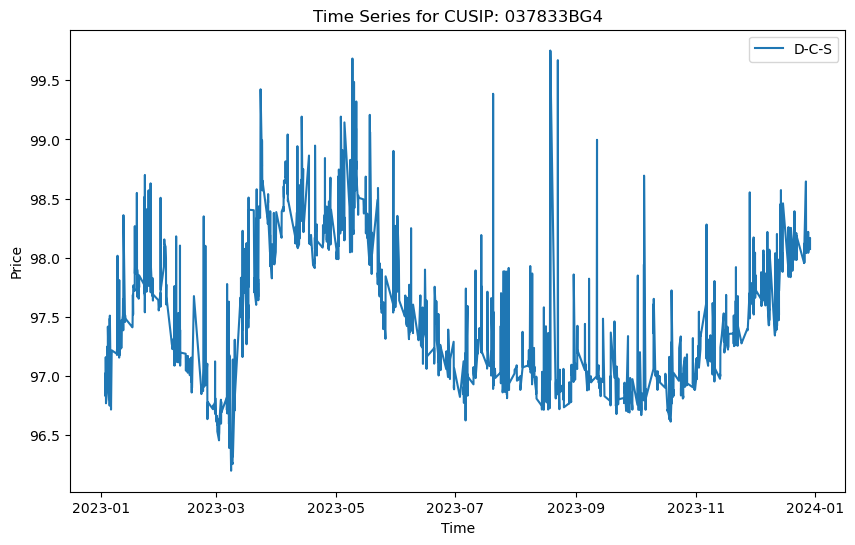

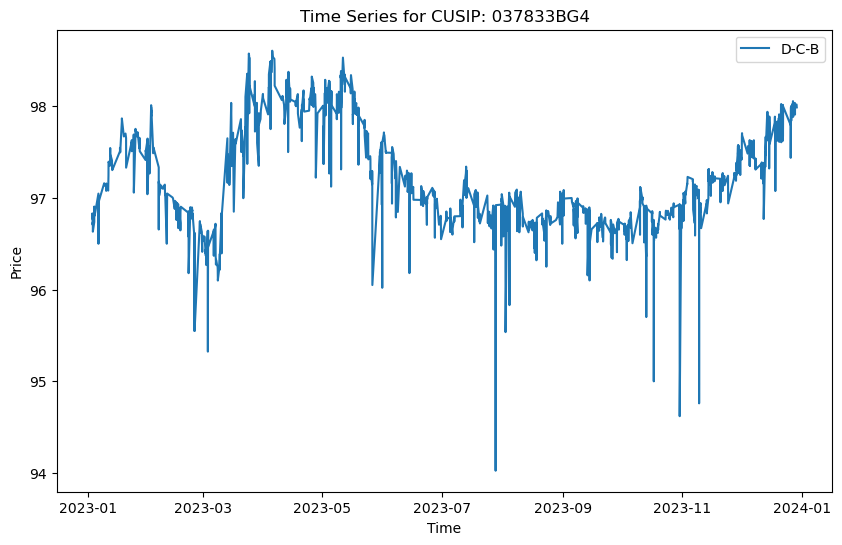

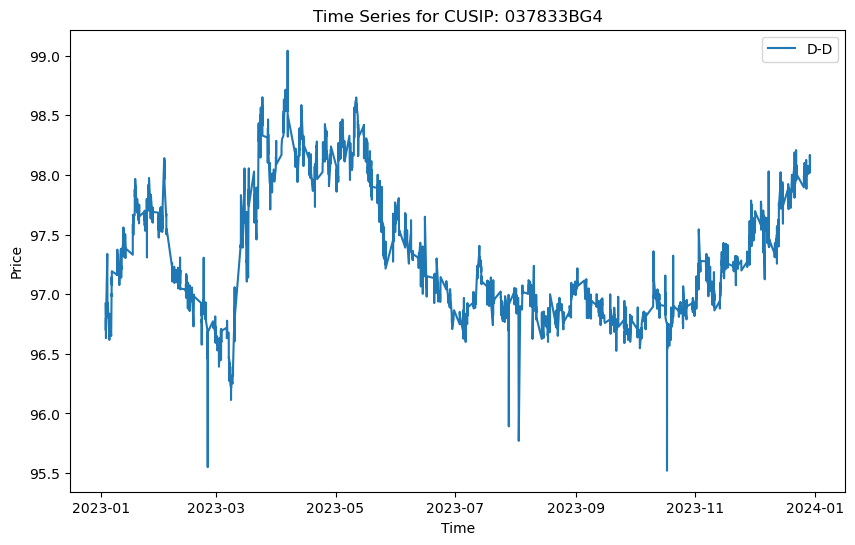

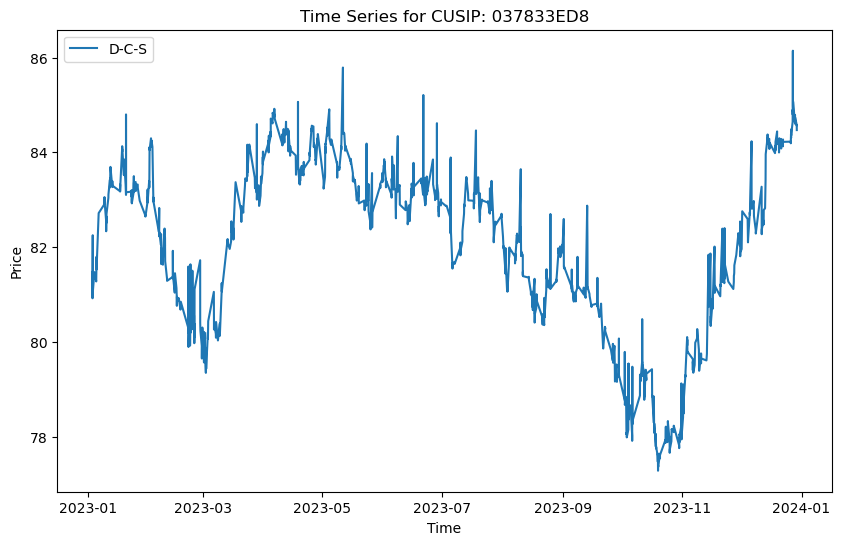

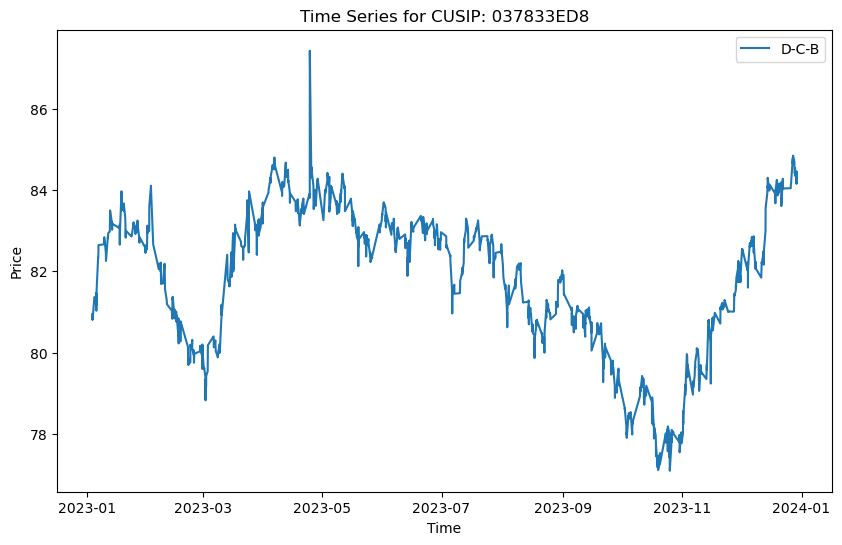

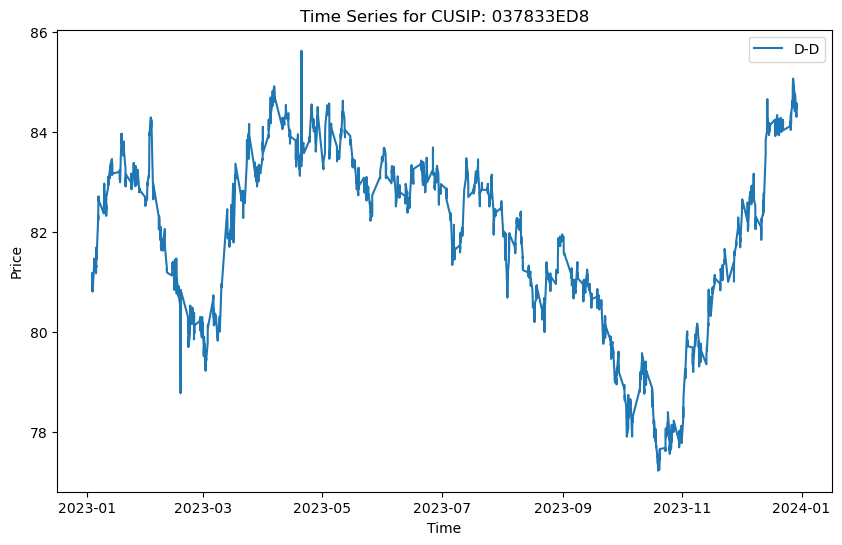

In [46]:
# Sum the trade volume for each CUSIP
cusip_volumes = filtered_data .groupby('CUSIP')['TRADE_VOLUME'].sum().sort_values(ascending=False)
top_cusips_by_volume = cusip_volumes.head(10)
print("Top 10 CUSIPs by Volume:")
print(top_cusips_by_volume)

top_cusips = cusip_counts.head(10).index  # Choose top 10 CUSIPs

# Analyze and plot data for each top CUSIP
for cusip in top_cusips:
    data_cusip = filtered_data [filtered_data ['CUSIP'] == cusip]
    
    # Filter by trade type and plot
    for trade_type in ['D-C-S', 'D-C-B', 'D-D']:
        data_trade = data_cusip[(data_cusip['TradeType'] == trade_type) | 
                                (data_cusip['CombinedTradeType'] == trade_type)]
        plt.figure(figsize=(10, 6))
        plt.plot(data_trade['TRADE_DATETIME'], data_trade['PRICE'], label=trade_type)
        plt.title(f'Time Series for CUSIP: {cusip}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


Top 10 CUSIPs by Volume:
CUSIP
037833BX7    1.350957e+11
037833EW6    1.311873e+11
037833EP1    1.255444e+11
037833EQ9    1.222533e+11
037833EV8    1.151455e+11
037833ER7    1.079306e+11
037833BY5    1.002093e+11
037833ET3    9.905213e+10
037833EB2    9.232959e+10
037833DT4    8.531823e+10
Name: TRADE_VOLUME, dtype: float64


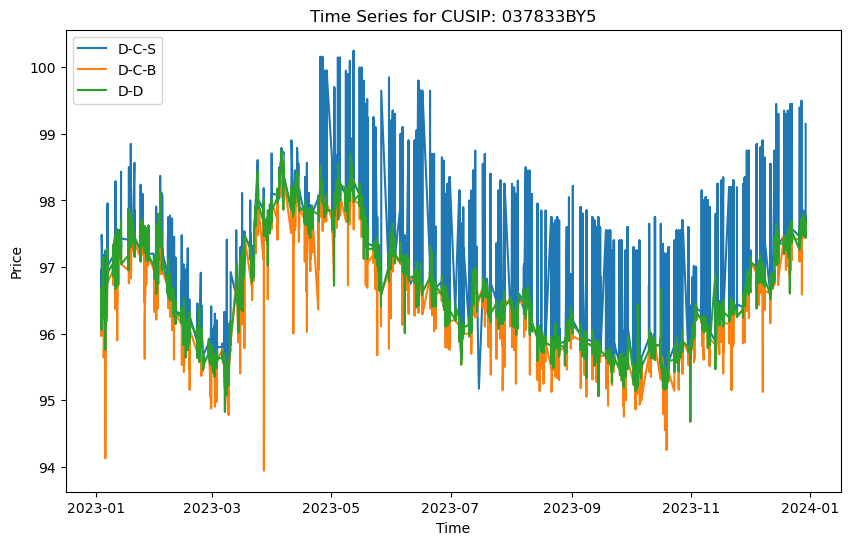

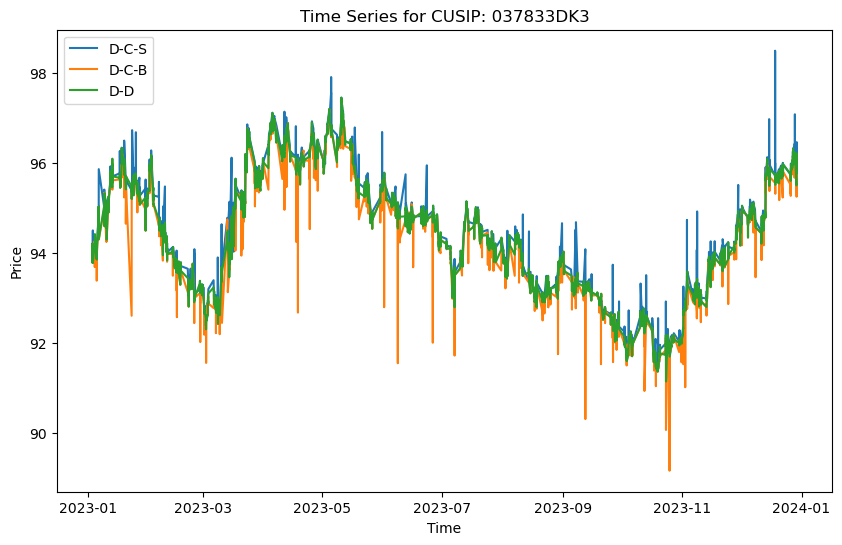

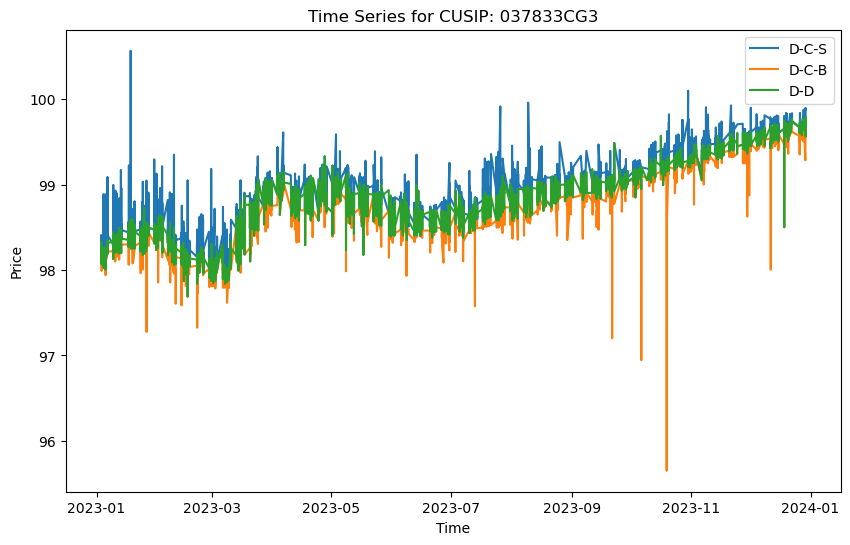

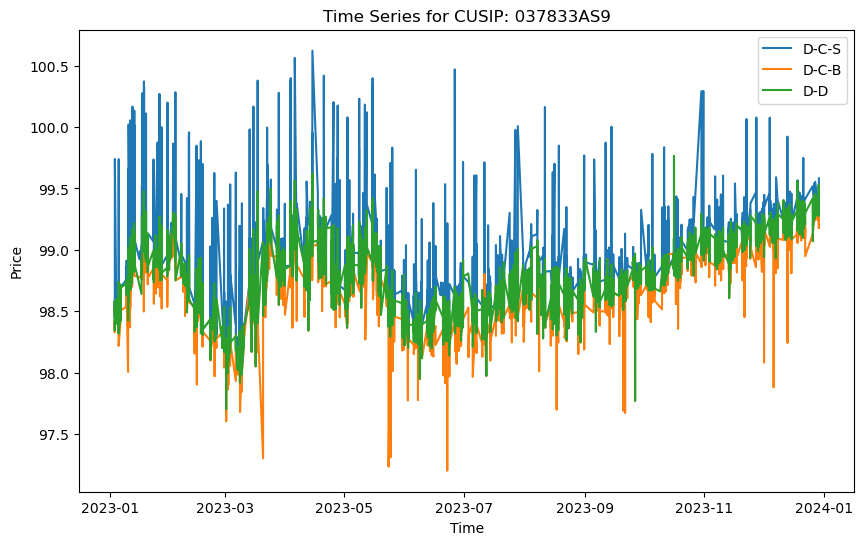

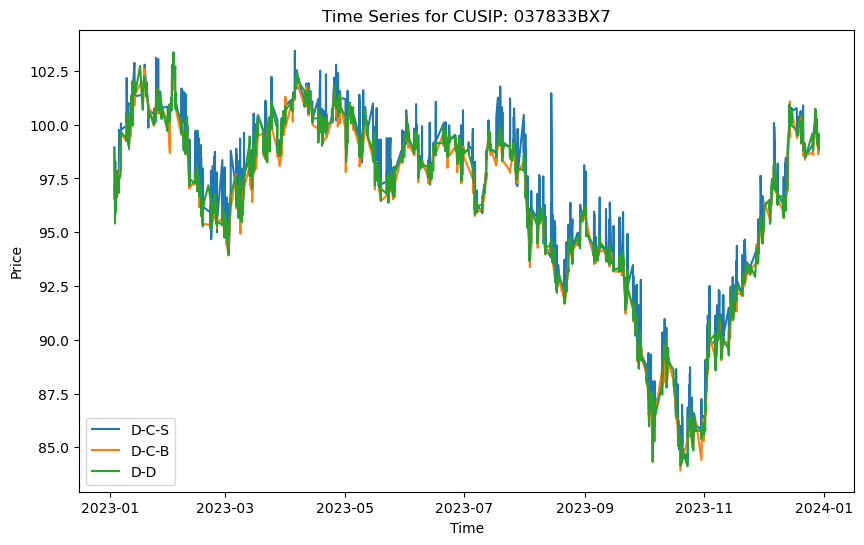

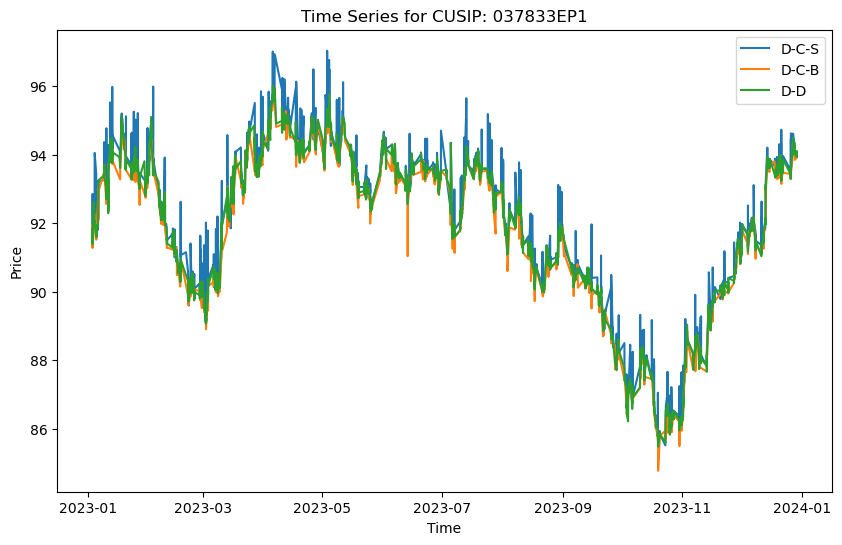

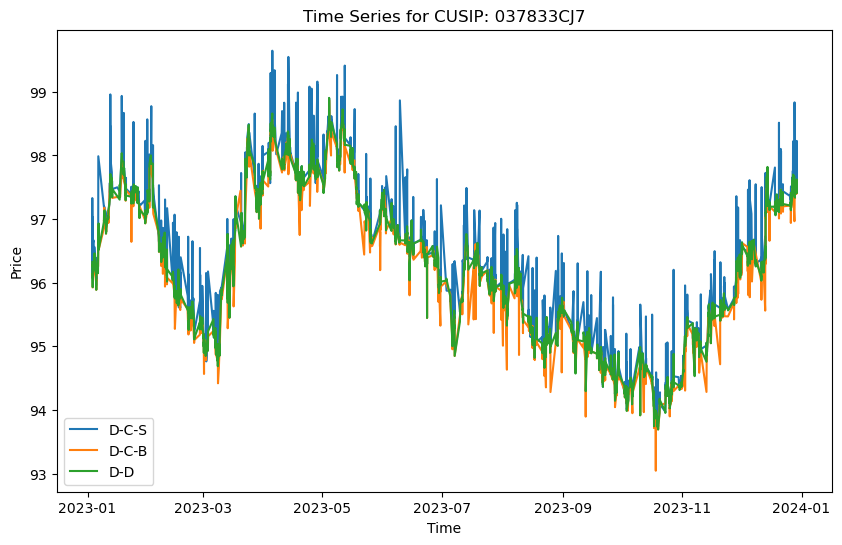

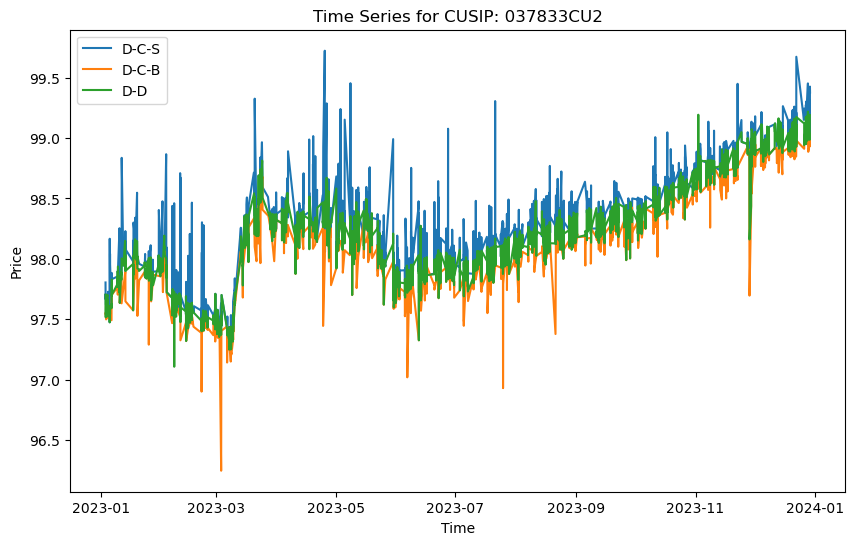

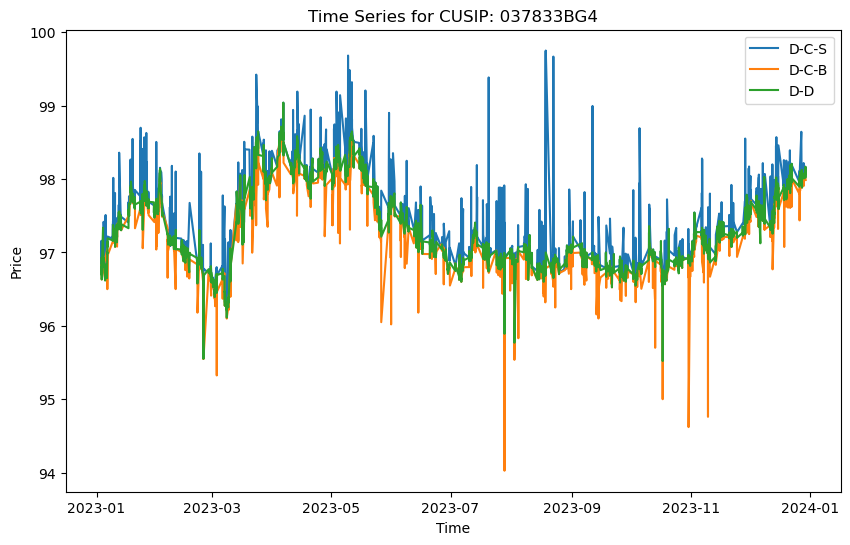

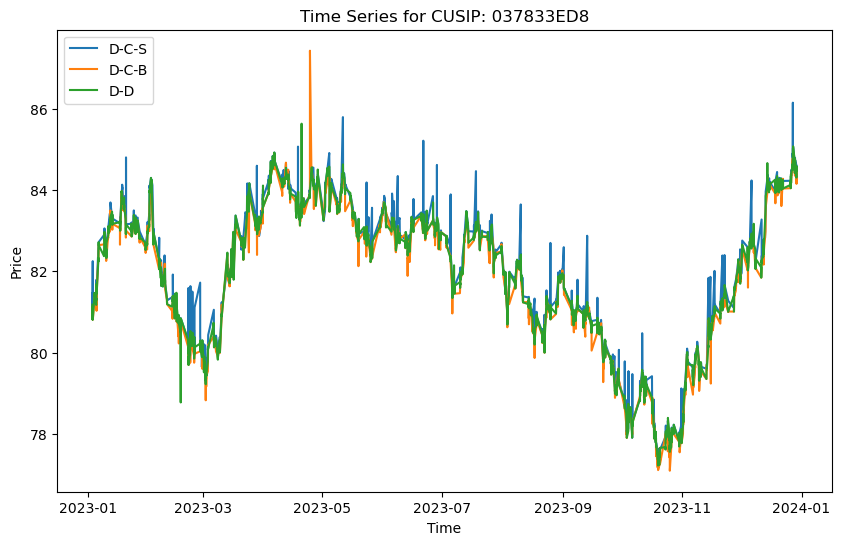

In [47]:
cusip_volumes = filtered_data.groupby('CUSIP')['TRADE_VOLUME'].sum().sort_values(ascending=False)
top_cusips_by_volume = cusip_volumes.head(10)
print("Top 10 CUSIPs by Volume:")
print(top_cusips_by_volume)

# Store the top 10 CUSIPs
top_cusips = top_cusips_by_count.index

# Analyze and plot data for each top CUSIP
for cusip in top_cusips:
    data_cusip = filtered_data[filtered_data['CUSIP'] == cusip]
    
    plt.figure(figsize=(10, 6))
    
    # Define trade types and plot data for each type on the same chart
    for trade_type in ['D-C-S', 'D-C-B', 'D-D']:
        data_trade = data_cusip[(data_cusip['TradeType'] == trade_type) | 
                                (data_cusip['CombinedTradeType'] == trade_type)]
        
        plt.plot(data_trade['TRADE_DATETIME'], data_trade['PRICE'], label=trade_type)
        
    plt.title(f'Time Series for CUSIP: {cusip}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# Sort the data
data.sort_values(by=['CUSIP', 'TRADE_DATETIME'], inplace=True)

# Calculate the time delta between consecutive trades
data['Time_Delta'] = data.groupby('CUSIP')['TRADE_DATETIME'].diff()

# Calculate the average time delta
average_time_delta = data['Time_Delta'].mean()

print(average_time_delta)


freq_string = f'{int(average_time_delta.total_seconds() / 60)}T'

data.set_index('TRADE_DATETIME', inplace=True)

# Group by 'CUSIP' and resample based on the average time delta, then calculate the last price in each period
price_resampled = data.groupby('CUSIP').resample(freq_string)['PRICE'].last()

# Calculate returns by CUSIP
returns = price_resampled.groupby(level=0).pct_change().dropna()

# Filter based on 'TradeType'
d2c_data = data[data['CombinedTradeType'].str.contains('D-C')]
d2d_data = data[data['CombinedTradeType'] == 'D-D']

# Resample and calculate returns for D2C and D2D
d2c_returns = d2c_data.groupby('CUSIP').resample(freq_string)['PRICE'].last().groupby(level=0).pct_change().dropna()
d2d_returns = d2d_data.groupby('CUSIP').resample(freq_string)['PRICE'].last().groupby(level=0).pct_change().dropna()

# Print the results
print(returns.head())
print(d2c_returns.head())
print(d2d_returns.head())


#data = data.dropna(subset=[returns])
from statsmodels.tsa.stattools import adfuller

result = adfuller(returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation:
# If ADF Statistic < critical values and p-value is low, the series is stationary.


#data_d2c = data_d2c.dropna(subset=['D2C_Returns'])
from statsmodels.tsa.stattools import adfuller

result = adfuller(d2c_returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation:
# If ADF Statistic < critical values and p-value is low, the series is stationary.


#data_d2d = data_d2d.dropna(subset=['D2D_Returns'])
from statsmodels.tsa.stattools import adfuller

result = adfuller(d2d_returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation:
# If ADF Statistic < critical values and p-value is low, the series is stationary.


In [71]:
cusip_data = filtered_data[filtered_data['CUSIP'] == "037833BX7"]

# Calculate the time delta between consecutive trades
cusip_data['Time_Delta'] = cusip_data['TRADE_DATETIME'].diff().dt.total_seconds()

# Handle zero and NaN time deltas
cusip_data = cusip_data[cusip_data['Time_Delta'] > 0]
cusip_data['Time_Delta'].fillna(method='bfill', inplace=True)  # Backfill any NaNs that may have been introduced

# Calculate the average time delta for a reasonable time step (in seconds)
average_time_delta =(1/4)* cusip_data['Time_Delta'].median()

# Normalize returns
cusip_data['Price_Returns'] = cusip_data['PRICE'].pct_change()
cusip_data['Normalized_Returns'] = cusip_data['Price_Returns'] / cusip_data['Time_Delta'] * average_time_delta


cusip_data


/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_82749/2130487237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cusip_data['Time_Delta'] = cusip_data['TRADE_DATETIME'].diff().dt.total_seconds()


CUSIP          ISIN TICKER    SECURITY_TYPE      TRADE_DATETIME  \
18      037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-01-03 04:19:00   
28      037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-01-03 07:41:00   
86      037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-01-03 08:39:00   
110     037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-01-03 09:06:00   
174     037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-01-03 09:54:00   
...           ...           ...    ...              ...                 ...   
308308  037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-12-29 11:32:00   
308337  037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-12-29 11:51:00   
308391  037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-12-29 12:16:00   
308410  037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-12-29 12:33:00   
308452  037833BX7  US037833BX70   AAPL  AAPL 4.65 02/46 2023-12-29 13:00:00   

           PRICE    SPREAD  QUANTITY  ASSUMED_QUANTITY REPORTING_PARTY_SIDE  \
18      98.48900  0.712046   30000.0             30000                    S   
28      96.81300  0.845991  225000.0            225000                    S   
86      96.50176  0.866143  105000.0            105000                    S   
110     97.04200  0.846021  115000.0            115000                    S   
174     97.26500  0.842549   25000.0             25000                    S   
...          ...       ...       ...               ...                  ...   
308308  99.08500  0.540643   10000.0             10000                    S   
308337  99.55800  0.526887   10000.0             10000                    S   
308391  98.75800  0.568802  150000.0            150000                    B   
308410  98.98500  0.564019   20000.0             20000                    S   
308452  99.17100  0.529307   69000.0             69000                    B   

        ...         ANNOUNCEMENT_DATE ISSUE_DATE MATURITY_DATE SECTOR  \
18      ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
28      ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
86      ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
110     ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
174     ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
...     ...                       ...        ...           ...    ...   
308308  ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
308337  ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
308391  ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
308410  ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   
308452  ... 2016-02-16 00:00:00+00:00  2/23/2016    2046-02-23    TMT   

       TRADE_VOLUME CombinedTradeType TradeType  Time_Delta Price_Returns  \
18        2954670.0               D-D     D-D-S       420.0           NaN   
28       21782925.0               D-D     D-D-S     12120.0     -0.017017   
86       10132684.8               D-D     D-D-S      3480.0     -0.003215   
110      11159830.0               D-C     D-C-S      1620.0      0.005598   
174       2431625.0               D-C     D-C-S      2880.0      0.002298   
...             ...               ...       ...         ...           ...   
308308     990850.0               D-D     D-D-S      3900.0      0.002895   
308337     995580.0               D-C     D-C-S      1140.0      0.004774   
308391   14813700.0               D-C     D-C-B      1500.0     -0.008036   
308410    1979700.0               D-D     D-D-S      1020.0      0.002299   
308452    6842799.0               D-C     D-C-B      1620.0      0.001879   

       Normalized_Returns  
18                    NaN  
28              -0.000463  
86              -0.000305  
110              0.001140  
174              0.000263  
...                   ...  
308308           0.000245  
308337           0.001382  
308391          -0.001768  
308410           0.000744  
3084

cusip_data = filtered_data[filtered_data['CUSIP'] == "037833BX7"]

cusip_data['Time_Delta'] = cusip_data['TRADE_DATETIME'].diff().dt.total_seconds()

cusip_data = cusip_data.dropna(subset=['Time_Delta'])

cusip_data['Price_Returns'] = cusip_data['PRICE'].pct_change()

# Normalize returns by the time delta
seconds_in_year = 365.25 * 24 * 60 * 60  # Average number of seconds in a year
cusip_data['Normalized_Returns'] = cusip_data['Price_Returns'] / cusip_data['Time_Delta'] * seconds_in_year

# Drop any remaining NA values generated by pct_change()
cusip_data = cusip_data.dropna(subset=['Normalized_Returns'])



In [67]:
#white noise test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(cusip_data['Normalized_Returns'].dropna(), lags = 20)

lb_stat     lb_pvalue
1   36.003606  1.969527e-09
2   37.802483  6.184365e-09
3   37.803198  3.111057e-08
4   53.113545  8.068051e-11
5   54.526775  1.633289e-10
6   54.619661  5.531940e-10
7   55.465523  1.205531e-09
8   56.240044  2.532925e-09
9   57.718059  3.681304e-09
10  62.229076  1.368833e-09
11  62.539307  3.118378e-09
12  62.597485  7.556010e-09
13  65.071783  6.397890e-09
14  65.093163  1.472343e-08
15  68.671429  7.694874e-09
16  71.024170  6.597929e-09
17  75.278606  2.610799e-09
18  75.846857  4.519852e-09
19  75.900770  9.360396e-09
20  78.048842  8.395519e-09

In [68]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the normalized returns
adf_test = adfuller(cusip_data['Normalized_Returns'].dropna())

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


ADF Statistic: -9.086126154957231
p-value: 3.935946476700137e-15


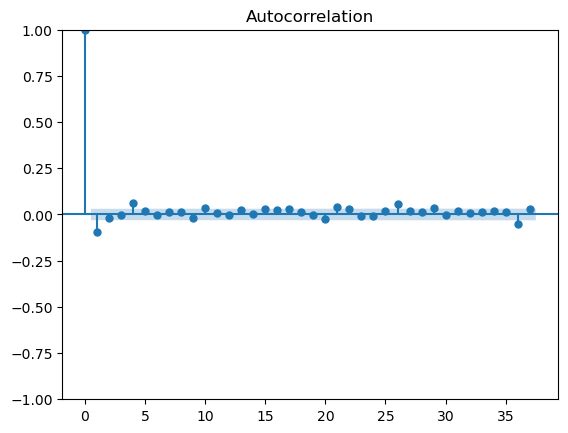

/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


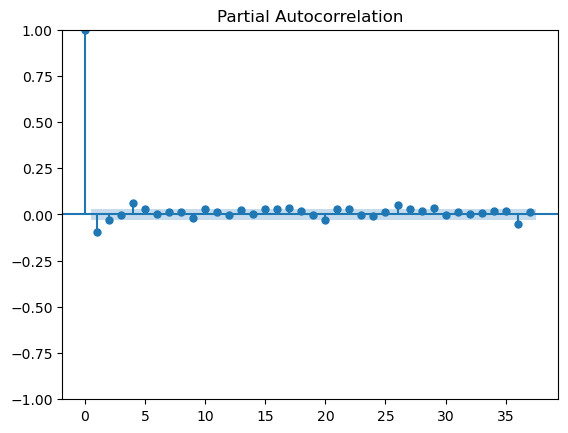

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plot_acf(cusip_data['Normalized_Returns'].dropna())
plt.show()

plot_pacf(cusip_data['Normalized_Returns'].dropna())
plt.show()


In [70]:

# Assuming we have already determined p, d, q from ACF and PACF analysis
p = 1  # Autoregressive terms
d = 0  # Differencing order
q = 1  # Moving average terms

# Fit the ARIMA model
arima_model = ARIMA(cusip_data['Normalized_Returns'], order=(p, d, q))
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())

# Perform in-sample prediction and out-of-sample forecasting
# Define the train size and forecast steps according to your dataset
train_size = int(len(cusip_data) * 0.8)
test_size = len(cusip_data) - train_size
forecast_steps = test_size  # or any other number of steps you want to forecast

# In-sample prediction
in_sample_preds = arima_result.predict(start=train_size, end=len(cusip_data)-1)

# Out-of-sample forecasting
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=cusip_data.index[-1], periods=forecast_steps, freq='T') # 'T' for minute frequency

# Print forecast
print(forecast.predicted_mean)


/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     Normalized_Returns   No. Observations:                 4088
Model:                 ARIMA(1, 0, 1)   Log Likelihood               12004.252
Date:                Wed, 31 Jan 2024   AIC                         -24000.503
Time:                        15:40:11   BIC                         -23975.240
Sample:                             0   HQIC                        -23991.558
                               - 4088                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.966      0.000       0.000       0.001
ar.L1          0.2103      0.120      1.748      0.080      -0.025       0.446
ma.L1         -0.3071      0.111     -2.754      0.0

/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/irislee/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
